imports

In [4]:
import csv
import numpy as np
import sklearn as sk
import matplotlib.pylab as plt
%matplotlib inline
import copy as cp
import pickle
import pandas as pd
import os.path
import seaborn as sns
from progressbar import ProgressBar

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import re
import sys
import tarfile

from six.moves import urllib
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

Tensorflow things

In [5]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string(
    'model_dir', '/tmp/imagenet',
    """Path to classify_image_graph_def.pb, """
    """imagenet_synset_to_human_label_map.txt, and """
    """imagenet_2012_challenge_label_map_proto.pbtxt.""")
tf.app.flags.DEFINE_string('image_file', '',
                           """Absolute path to image file.""")
tf.app.flags.DEFINE_integer('num_top_predictions', 5,
                            """Display this many predictions.""")

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long

class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
    
#print all op names
def print_ops():
    create_graph()
    with tf.Session() as sess:
        ops = sess.graph.get_operations()
        for op in ops:
            print(op.name)

In [32]:
def maybe_download_and_extract():
  """Download and extract model tar file."""
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath,
                                             reporthook=_progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

Functions to generate results

In [8]:
def compute_all_distances(X, metric='euclidean'):
    """ Computes pairwise distances for points stored row-wise in X """
    return squareform(pdist(X, metric=metric))

def representation_metric_all_samples(dist, y):
    """ 
    Given a pairwise distance matrix dist and labels y, computes ratio of
    pairwise average intra-class distance to average inter-class distance
    """
    assert len(dist.shape) == 2 and dist.shape[0] == dist.shape[1], (
        'Distance matrix is not square!')
    
    within_group_distance = 0.
    between_group_distance = 0.
    num_within, num_between = 0, 0
    
    labels = np.unique(y)
    for label in labels:
        label_mask = y==label
        
        within_group_distance += dist[label_mask].T[label_mask].sum()
        between_group_distance += dist[label_mask].T[~label_mask].sum()
        
        num_within += label_mask.sum() * (label_mask.sum()-1) / 2
        num_between += label_mask.sum() * (~label_mask).sum()
    
    return (between_group_distance / within_group_distance 
            * num_within / num_between 
            * 2)
def compute_representation_metric(X,y,metric='euclidean'):
    return representation_metric_all_samples(compute_all_distances(X, metric),y)

In [12]:
def permute_labels(y):
    """ Permutes the numpy array y """
    ls = cp.copy(y)
    np.random.shuffle(ls)
    return ls

In [13]:
def compute_clustering_stats(data, labels, num_iter):
    """ Computes clustering goodness and significance using permutation testing """
    
    dist = compute_all_distances(data)
    metric_for_permuted = (
        [representation_metric_all_samples(dist, labels if i==0 else permute_labels(labels)) 
         for i in range(num_iter)])
    
    p = float((metric_for_permuted >= metric_for_permuted[0]).sum()) / num_iter
    
    stats = {
        'true': metric_for_permuted[0],
        'metric': metric_for_permuted[1:],
        'p': p # p_value
    }
    return stats

In [14]:
def import_labels(labels_file_path):
    with open(labels_file_path,'rU') as f:
        return  np.asanyarray(pd.read_csv(f).Class).astype(int)

In [15]:
# function to create list of images
def dataset_gen(samplesPath, data_dir):
    with open(samplesPath,'rU') as f:
        return [getImage(data_dir,im) for im in pd.read_csv(f).Id]
    
    
def getImage(data_dir,im):
    filepath = data_dir+'/'+im+'.jpg'
    if not os.path.exists(filepath):
        print('File does not exist %s', filepath)
    return open(filepath, 'rb').read()

In [16]:
# function to generate features
def generateFeatures(layer_name ,dataset):
    """Generate and save features as csv for a particular layer and dataset.
    Keyword arguments:
    layer_name -- String: the name of the tensor, ex 'pool_3:0'
    dataset -- Generator: an iterator over the image dataset
    """ 
    create_graph()
    all_features = []
    with tf.Session() as sess:
        layer = sess.graph.get_tensor_by_name(layer_name)
        for image_data in dataset:
            features = sess.run(layer,{'DecodeJpeg/contents:0': image_data})
            features = np.reshape(features,(np.product(features.shape)))
            all_features.append(features)
    return np.asanyarray(all_features).astype(float)


In [17]:
tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

def plot_TSNE(data,labels):
    points = tsne_model.fit_transform(data)
    df = pd.DataFrame(data=np.column_stack([points,labels]), columns=["x","y","class"])
    fig = sns.lmplot("x", "y", data=df, hue='class', fit_reg=False)
    sns.plt.show()
    return fig

In [18]:
def plotStats(layer_stats):
    layer_names = layer_stats.keys() 
    df = pd.DataFrame(data = np.column_stack([layer_stats[layer]["metric"] for layer in layer_names]),
                      columns = layer_names)
    df2 = pd.DataFrame(data = np.column_stack([layer_stats[layer]["true"] for layer in layer_names]),
                      columns = layer_names)
    sns.violinplot(data = df, inner = None)
    sns.pointplot(data = df2, join=False,color="#bb3f3f")
    sns.plt.show()
    

In [19]:
def run(layers, datasets, labels):
    for i, (classes, dataset) in enumerate(zip(labels, datasets)):
        layer_results = {}
        
        for layer in layers:
            print("Generating features for dataset %d layer %s" % (i, layer))
            features = generateFeatures(layer, dataset)
            
            print("t-SNE for dataset %d layer %s" % (i, layer))
            tsne_fig = plot_TSNE(features,classes)
            
            print("Generating stats for dataset %d layer %s" % (i, layer))
            stats = compute_clustering_stats(features,classes,1000)
            layer_results[layer] = stats
            
            print("p-value for dataset %d, layer %s: %s" % (i, layer, stats['p']))
            del features
        
        print("Stats for dataset %d" % i)
        plotStats(layer_results)
        del dataset
        # plot the stats for the dataset, each layer will have a boxplot for the metric 
        # with permuted labels and true value



Input Data and Run Model

In [37]:
layers = ["pool_3:0","pool_2:0","pool_1:0"]
datasets = [dataset_gen("datasets/images/trainLabels.csv","datasets/images"),
            dataset_gen("datasets/emotion/samples.csv","datasets/emotion")]
labels = [import_labels("datasets/images/trainLabels.csv"),
         import_labels("datasets/emotion/samples.csv")]
#ADD MNST TO THE LISTS

Generating features for dataset 0 layer pool_2:0
t-SNE for dataset 0 layer pool_2:0


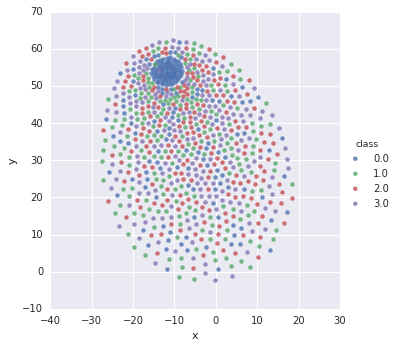

Generating stats for dataset 0 layer pool_2:0
p-value for dataset 0, layer pool_2:0: 0.0
Stats for dataset 0


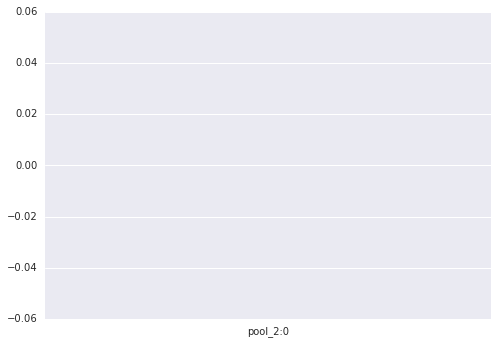

In [40]:
run(layers, datasets, labels)